<a href="https://colab.research.google.com/github/gulabpatel/Computer_Vision/blob/main/04_tomasi_kanade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

Load Measurement Matrix

In [ ]:
measurement = np.loadtxt("https://raw.githubusercontent.com/phoolpreet/CV_Stuff/main/line2.txt")
print(measurement.shape)

(50, 211)


Visualize measurement matrix

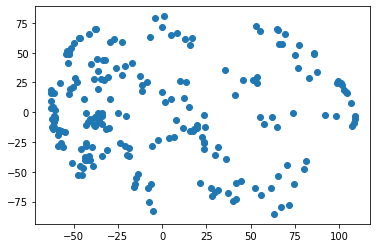

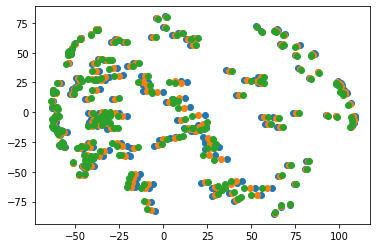

In [ ]:
# one frame
plt.scatter(measurement[0], measurement[1])
plt.show()
# three frames
plt.scatter(measurement[0], measurement[1])
plt.scatter(measurement[2], measurement[3])
plt.scatter(measurement[4], measurement[5])
plt.show()

Initial Factorize Measurements using SVD

In [ ]:
u, s, vh = np.linalg.svd(measurement)
s =  s[0:3]
s = np.sqrt(s)
proto_motion = np.dot(u[:, 0:3], np.diag(s))
proto_struct = np.dot(np.diag(s), vh[0:3, :])

Linear constraint for removing ambiguity

In [ ]:
def linearize_constraint(a:np.ndarray, b:np.ndarray):
  a1 = a[0]
  a2 = a[1]
  a3 = a[2]
  b1 = b[0]
  b2 = b[1]
  b3 = b[2]
  c = np.array([a1*b1, a1*b2 + a2*b1, a1*b3 + a3*b1, a2*b2, a2*b3 + a3*b2, a3*b3])
  return c

Gather constraint for all the frames \\
$a_{i1} \cdot G G^T \cdot a_{i1} = 1$ \\
$a_{i2} \cdot G G^T \cdot a_{i2} = 1$ \\
$a_{i1} \cdot G G^T \cdot a_{i2} = 0$ \\

$Ax = b$

In [ ]:
lst_A = []
lst_b = []
NUM_FRAMES = int(proto_motion.shape[0] / 2)
for f in range(NUM_FRAMES):
  r1 = proto_motion[2 * f    ].copy()
  r2 = proto_motion[2 * f + 1].copy()
  
  c1 = linearize_constraint(r1, r1)
  c2 = linearize_constraint(r2, r2)
  c3 = linearize_constraint(r1, r2)
  lst_A.append(c1)
  lst_A.append(c2)
  lst_A.append(c3)
  lst_b.append(1)
  lst_b.append(1)
  lst_b.append(0)

mat_A = np.vstack(lst_A)
vec_b = np.vstack(lst_b)

ls_result = np.linalg.lstsq(mat_A, vec_b, rcond=None)
x = ls_result[0]

# unvectorize x in G_Gt
G_Gt = np.zeros((3, 3))
k = 0
for i in range(3):
  for j in range(i, 3):
    G_Gt[j, i] = x[k]
    G_Gt[i, j] = x[k]
    k = k + 1

Recover $G$ from $G \cdot G^T$

In [ ]:
# get G from G_Gt through SVD
u, s, vh = np.linalg.svd(G_Gt)
for i in range(s.shape[0]):
  if s[i] < 0:
    s[i] = 0
s_mat = np.diag(s)  # works coz u and v are both 3x3
s_mat_sqrt = np.sqrt(s_mat)
G = np.dot(u, np.dot(s_mat_sqrt, vh))

Obtain final structure and motion

In [ ]:
motion = np.dot(proto_motion, G)
struct = np.dot(np.linalg.inv(G), proto_struct)

Visualize Structure

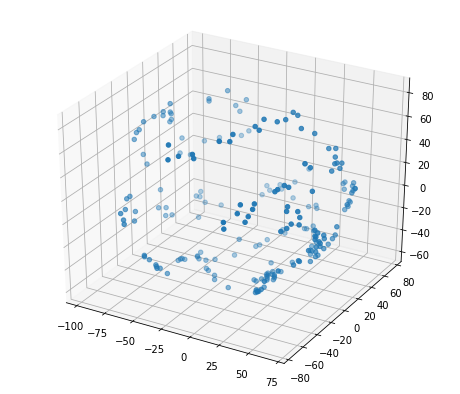

In [ ]:
fig = plt.figure(figsize = (8, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(struct[0], struct[1], struct[2])
plt.show()

-----------------------